In [1]:
True

True

# Example: load processed run data, perform azimuthal integration and plot
Note: When loading data from the same hdf5 file (with changed contents), you may have to restart the kernel to avoid getting a cached version of the old data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import h5py
import xarray as xr
import os
from tqdm.auto import tqdm
from os.path import join
from time import strftime

from karabo_data.geometry2 import DSSC_1MGeometry

In [2]:
%matplotlib widget

In [3]:
def merge_images(image1, image2):
    '''Merge two processed run images by calculating the weighted sum
    of data variables.'''
    sum_keys = ['pumped', 'unpumped', 'xgm_pumped', 'xgm_unpumped']
    run1 = image1.run.values
    run2 = image2.run.values
    image1 = image1.drop('run')
    image2 = image2.drop('run')
    
    for k in sum_keys:
        image2[k] = image2[k] * image2.sum_count
        image1[k] = image1[k] * image1.sum_count

    merged = xr.concat([image1, image2], dim='image')
    merged = merged.sum('image')

    for k in sum_keys:
        merged[k] = merged[k] / merged.sum_count
    merged['run'] = np.append(run1, run2)
    return merged


def load_geom():
    quad_pos = [
        (-124.100,    3.112),  # TR
        (-133.068, -110.604),  # BR
        (   0.988, -125.236),  # BL
        (   4.528,   -4.912)   # TL
        ]
    path = '/gpfs/exfel/sw/software/exfel_environments/misc/git/karabo_data/docs/dssc_geo_june19.h5'
    geom = DSSC_1MGeometry.from_h5_file_and_quad_positions(path, quad_pos)
    return geom


class azimuthal_integrator(object):
    def __init__(self, imageshape, center, polar_range, dr=2, rmin=0):
        '''
        Create a reusable integrator for repeated azimuthal integration of similar
        images. Calculates array indices for a given parameter set that allows
        fast recalculation.
        
        Parameters
        ==========
        imageshape : tuple of ints
            The shape of the images to be integrated over.
            
        center : tuple of ints
            center coordinates in pixels
        
        polar_range : tuple of ints
            start and stop polar angle (in degrees) to restrict integration to wedges
        
        dr : int, default 2
            radial width of the integration slices. Takes non-square DSSC pixels into account.
        
        Returns
        =======
        ai : azimuthal_integrator instance
            Instance can directly be called with image data:
            > az_intensity = ai(image)
            radial distances and the polar mask are accessible as attributes:
            > ai.distance
            > ai.polar_mask
        '''
        self.shape = imageshape
        self.dr = dr
        cx, cy = center
        sx, sy = imageshape
        xcoord, ycoord = np.ogrid[:sx, :sy]
        xcoord -= cx
        ycoord -= cy

        # distance from center, hexagonal pixel shape taken into account
        dist_array = np.hypot(xcoord * 204 / 236, ycoord)

        # array of polar angles
        tmin, tmax = np.deg2rad(np.sort(polar_range)) % np.pi
        polar_array = np.arctan2(xcoord, ycoord)
        polar_array = np.mod(polar_array, np.pi)
        self.polar_mask = (polar_array > tmin) * (polar_array < tmax)

        self.maxdist = min(sx  - cx, sy  - cy)
        self.mindist = max(rmin, dr)

        ix, iy = np.indices(dimensions=(sx, sy))
        self.index_array = np.ravel_multi_index((ix, iy), (sx, sy))

        self.distance = np.array([])
        self.flat_indices = []
        for dist in range(self.mindist, self.maxdist, dr):
            ring_mask = self.polar_mask * (dist_array >= (dist - dr)) * (dist_array < dist)
            self.flat_indices.append(self.index_array[ring_mask])
            self.distance = np.append(self.distance, dist)
    
    def __call__(self, image):
        assert self.shape == image.shape, 'image shape does not match'
        image_flat = image.flatten()
        return np.array([np.nansum(image_flat[indices]) for indices in self.flat_indices])

In [4]:
geom = load_geom()

In [11]:
from imageio import imread
dssc_mask = imread('./dssc_mask_7.bmp')
dssc_mask = dssc_mask.astype(float)[..., 0] // 255
dssc_mask[dssc_mask==0] = np.nan

# dssc_mask = 1

# load aggregated run data

In [5]:
darkrun_nr = 133
run_nr = 132

In [20]:
image2 = image.copy()

In [6]:
datadir = 'processed_runs'

dark = xr.open_dataset(join(datadir, f'run{darkrun_nr}.h5'), group='data', autoclose=True)
image = xr.open_dataset(join(datadir, f'run{run_nr}_by-delay.h5'), group='data', autoclose=True)

In [7]:
for var in ['pumped', 'unpumped', 'pumped_dark', 'unpumped_dark']:
    image[var] = (image[var] - dark[var].values)

# image['pumped'] = image.pumped
# image['unpumped'] = image.unpumped

In [23]:
image = merge_images(image, image2)

# plot number of trains per delay step

In [9]:
fig, ax = plt.subplots(figsize=[6, 3])
ax.plot(image.scan_variable, image.sum_count[:, 0])

runstr = '+'.join([str(i) for i in [image.run.values]])

ax.set_xlabel('scan variable')
ax.set_ylabel('number of trains')
ax.grid(True)
ax.set_title(runstr)

# plt.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 1.0, '132')

# subtract intermediate darks and normalize
## XGM normalization

In [22]:
im_pumped = (image.pumped - image.pumped_dark) / image.xgm_pumped
im_unpumped = (image.unpumped - image.unpumped_dark) / image.xgm_unpumped

## TIM normalization

In [26]:
im_pumped = (image.pumped - image.pumped_dark) / (-image.tim_pumped)
im_unpumped = (image.unpumped - image.unpumped_dark) / (-image.tim_unpumped)

## no normalization

In [8]:
im_pumped = (image.pumped - image.pumped_dark)
im_unpumped = (image.unpumped - image.unpumped_dark)

## no intermediate darks

In [11]:
im_pumped = (image.pumped) / image.xgm_pumped
im_unpumped = (image.unpumped) / image.xgm_unpumped

# get a single averaged image to align the azimuthal integration

In [9]:
im_unpump_mean, center = geom.position_modules_fast(im_unpumped.mean('scan_variable'))
im_pump_mean, center = geom.position_modules_fast(im_pumped.mean('scan_variable'))

In [12]:
angle_range = [0, 179]
ai = azimuthal_integrator(im_pump_mean.shape, center, angle_range, dr=2)
norm = ai(~np.isnan(im_pump_mean * dssc_mask))

In [13]:
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(9, 4), sharex=True, sharey=True)

vmin, vmax = np.percentile(im_pump_mean[~np.isnan(im_pump_mean)], [1, 99])
ax1.imshow(dssc_mask * im_pump_mean, vmin=vmin, vmax=vmax, aspect=204/236)
vmin, vmax = np.percentile(im_unpump_mean[~np.isnan(im_unpump_mean)], [1, 99])
ax2.imshow(dssc_mask * im_unpump_mean, vmin=vmin, vmax=vmax, aspect=204/236)

runstr = '+'.join([str(i) for i in [image.run.values]])
ax1.set_title(f'run {runstr}')

# ax1.set_xlim(300, 850)
# ax1.set_ylim(330, 880)

# plt.tight_layout()

tstamp = strftime('%y%m%d_%H%M')
# fig.savefig(f'images/run{runstr}_{tstamp}_mean.png', dpi=300)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## optional: save a bitmap to draw a new mask

In [36]:
from imageio import imsave
im_pump_mean = np.nan_to_num(np.clip(im_pump_mean, vmin, vmax))
im_pump_mean /= im_pump_mean.max()
imsave('191014_run164_mean_1.bmp', 255 * im_pump_mean)

# difference image

In [22]:
fig, ax = plt.subplots()

scale = np.nanmean(im_unpump_mean) / np.nanmean(im_pump_mean)
m = ax.imshow(dssc_mask * (im_unpump_mean / im_pump_mean), vmin=.9, vmax=1.1)

cbar = plt.colorbar(m)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# azimuthal integration for each delay

In [27]:
az_pump = []
az_unpump = []
az_time = []

im_pumped_arranged = geom.position_modules_fast(im_pumped.values)[0]
im_unpumped_arranged = geom.position_modules_fast(im_unpumped.values)[0]

im_pumped_arranged[530:570, 615:790] = np.nan
im_unpumped_arranged[530:570, 615:790] = np.nan

for i in tqdm(range(len(im_pumped.scan_variable))):
    az_pump.append(ai(dssc_mask * im_pumped_arranged[i]) / norm)
    az_unpump.append(ai(dssc_mask * im_unpumped_arranged[i]) / norm)
    az_time.append(im_pumped.scan_variable[i])

az_pump = np.stack(az_pump)
az_unpump = np.stack(az_unpump)
az_time = np.stack(az_time)

# momentum transfer

In [28]:
coords = {'delay': az_time, 'distance': ai.distance}
azimuthal = xr.DataArray(az_pump, dims=['delay', 'distance'], coords=coords)
azimuthal = azimuthal.to_dataset(name='pumped')
azimuthal['unpumped'] = xr.DataArray(az_unpump, dims=['delay', 'distance'], coords=coords)

azimuthal = azimuthal.transpose('distance', 'delay')

t0 = 0#104.7
azimuthal['delay'] = t0 - azimuthal.delay

wl = 1.59e-9
detector_distance = 430e-3
azimuthal['delta_q'] = 2e-9 * np.pi * np.sin(np.arctan(azimuthal.distance * 204e-6 / detector_distance)) / wl

azimuthal = azimuthal.swap_dims({'distance': 'delta_q'})

# plot pumped/ unpumped separately

In [35]:
fig, [ax1, ax2] = plt.subplots(nrows=2, sharex=True, sharey=True)

xr.plot.imshow(azimuthal.pumped, ax=ax1)#, vmin=0, vmax=10e-5)
xr.plot.imshow(azimuthal.unpumped, ax=ax2)#, vmin=0, vmax=10e-4)

ax1.set_xlabel('')

runstr = '+'.join([str(i) for i in [image.run.values]])

ax1.set_title(f'run {runstr}')
plt.tight_layout(.5)

tstamp = strftime('%y%m%d_%H%M')

#fig.savefig(f'images/run{runstr}_{tstamp}_dark{darkrun_nr}_azimuthal.png', dpi=300)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# plot 2d magnetization and linescans

In [29]:
# qranges = np.linspace(80, 480, 8)
qranges = [0.15, .35, .5]
qwidth = 0.05

fig, [ax1, ax2] = plt.subplots(nrows=2, sharex=True, figsize=[6, 8])

xr.plot.imshow(azimuthal.pumped / azimuthal.unpumped, ax=ax1, add_colorbar=False, vmin=.8, vmax=1.02)
# xr.plot.imshow(azimuthal.pumped, ax=ax1, add_colorbar=False)#, vmin=.2, vmax=1.2)

runstr = '+'.join([str(i) for i in [image.run.values]])

ax1.set_title(f'run {runstr}')
ax1.set_xlabel('')
ax1.set_ylabel('$\Delta$q (1/nm)')
for i, q0 in enumerate(qranges):
    sel = (azimuthal.delta_q > q0) * (azimuthal.delta_q < (q0 + qwidth))
    val = (azimuthal.pumped / azimuthal.unpumped).where(sel).mean('delta_q')
    if i == 0:
        demag = val.copy()
#     val = (azimuthal.pumped / azimuthal.pumped[:, -1]).where(sel).mean('distance')
    ax2.plot(azimuthal.delay, val, '-', label=i)
    ax1.axhline(q0, c=f'C{i}', lw=1)
    ax1.axhline(q0 + qwidth, c=f'C{i}', lw=1)

# # ax2.legend()
ax2.set_xlabel('delay (ps)')
# # ax2.set_xlabel('photon energy (eV)')
ax2.set_ylabel('SAXS (pumped / unpumped)')
ax2.grid(True)
# # ax2.set_ylim(0.4, 1.1)

# plt.tight_layout()

tstamp = strftime('%y%m%d_%H%M')
fig.savefig(f'images/run{runstr}_{tstamp}_2d-delay_TIMnorm.png', dpi=300)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# scratch

In [43]:
from scipy.optimize import curve_fit
def demagcurve(t, t0, offset, tau_m, mag_m, tau_re, mag_re, conv=0.1):
    dt = t - t0
    demag = (offset - (mag_m - mag_re)
             + mag_m * np.exp(-dt / tau_m)
             - mag_re * np.exp(-dt / tau_re))
    demag[dt < 0] = offset
    if conv > 0:
        tstep = np.unique(-np.diff(dt))
        if not np.allclose(tstep, tstep):
            raise ValueError('time steps need to be uniform')
        t_gauss = np.arange(-2 * conv, 2 * conv + tstep[0], tstep[0])
        gauss = np.exp(-(t_gauss) ** 2 / (2 * (conv / 2.35) ** 2))
        gauss = gauss / gauss.sum()
        demag_conv = np.convolve(demag, gauss, mode='valid')
        demag[len(gauss) // 2:-len(gauss) // 2 + 1] = demag_conv
    return demag

In [44]:
guess = [0, 1, 1, .5, 5000, 0]

In [47]:
param, cov = curve_fit(demagcurve, demag.delay.values, demag.values, p0=guess)
demag_fit = demagcurve(demag.delay.values, *param)
noise = demag / demag_fit

In [48]:
param

array([0.00000000e+00, 6.22482628e-01, 1.00000000e+00, 5.00000000e-01,
       5.00000000e+03, 0.00000000e+00])

<IPython.core.display.Javascript object>


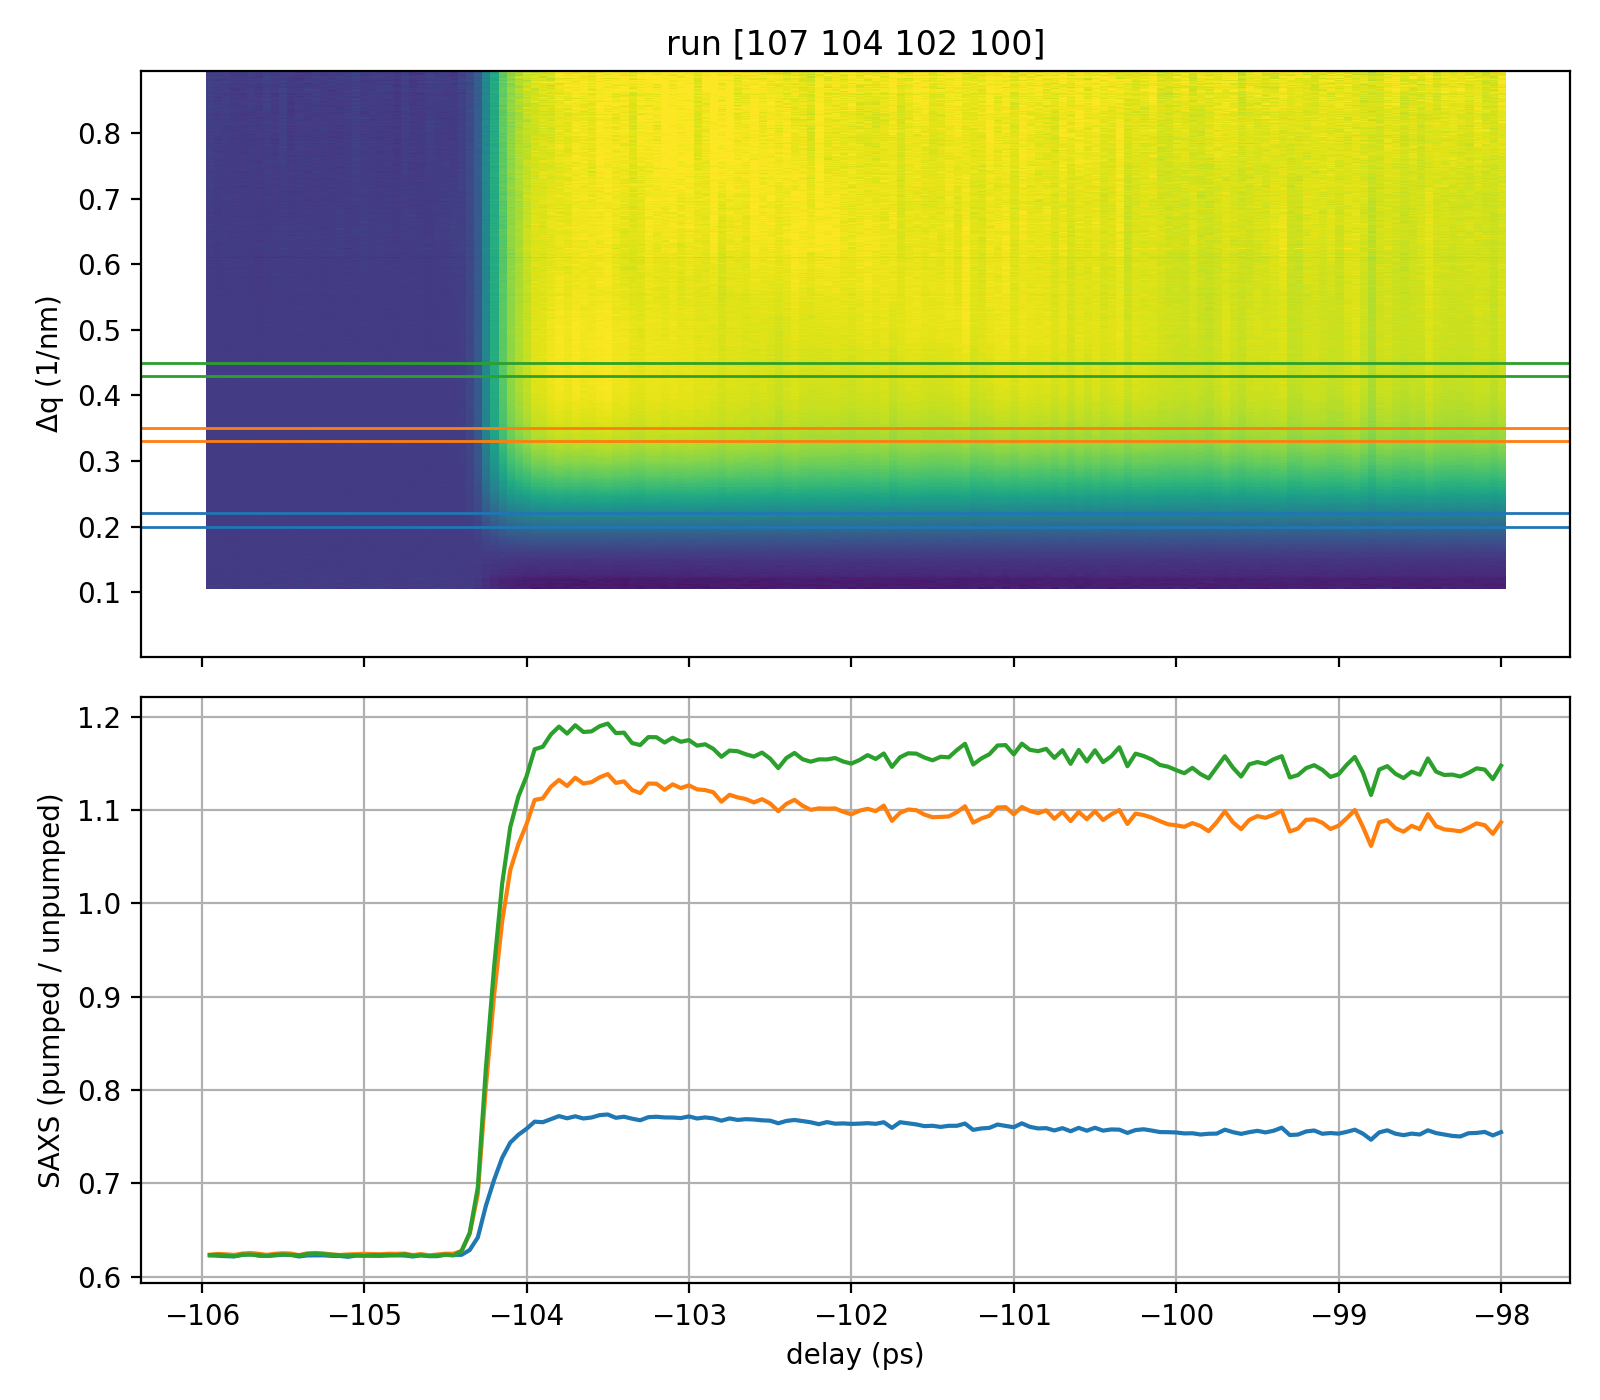

In [49]:
# qranges = np.linspace(80, 480, 8)
qranges = [0.2, 0.33, 0.43]
qwidth = 0.02

fig, [ax1, ax2] = plt.subplots(nrows=2, sharex=True, figsize=[8, 7])

xr.plot.imshow((azimuthal.pumped / azimuthal.unpumped) / (noise), ax=ax1, add_colorbar=False, vmin=.5, vmax=1.2)
# xr.plot.imshow(azimuthal.pumped, ax=ax1, add_colorbar=False)#, vmin=.2, vmax=1.2)

runstr = '+'.join([str(i) for i in [image.run.values]])

ax1.set_title(f'run {runstr}')
ax1.set_xlabel('')
ax1.set_ylabel('$\Delta$q (1/nm)')
for i, q0 in enumerate(qranges):
    sel = (azimuthal.delta_q > q0) * (azimuthal.delta_q < (q0 + qwidth))
    val = ((azimuthal.pumped / azimuthal.unpumped) / (noise)).where(sel).mean('delta_q')
#     val = (azimuthal.pumped / azimuthal.pumped[:, -1]).where(sel).mean('distance')
    ax2.plot(azimuthal.delay, val, '-', label=i)
    ax1.axhline(q0, c=f'C{i}', lw=1)
    ax1.axhline(q0 + qwidth, c=f'C{i}', lw=1)

# ax2.legend()
ax2.set_xlabel('delay (ps)')
# ax2.set_xlabel('photon energy (eV)')
ax2.set_ylabel('SAXS (pumped / unpumped)')
ax2.grid(True)
# ax2.set_ylim(0.4, 1.1)

plt.tight_layout()


tstamp = strftime('%y%m%d_%H%M')
fig.savefig(f'images/run{runstr}_{tstamp}_2d-delay.png', dpi=300)


<IPython.core.display.Javascript object>


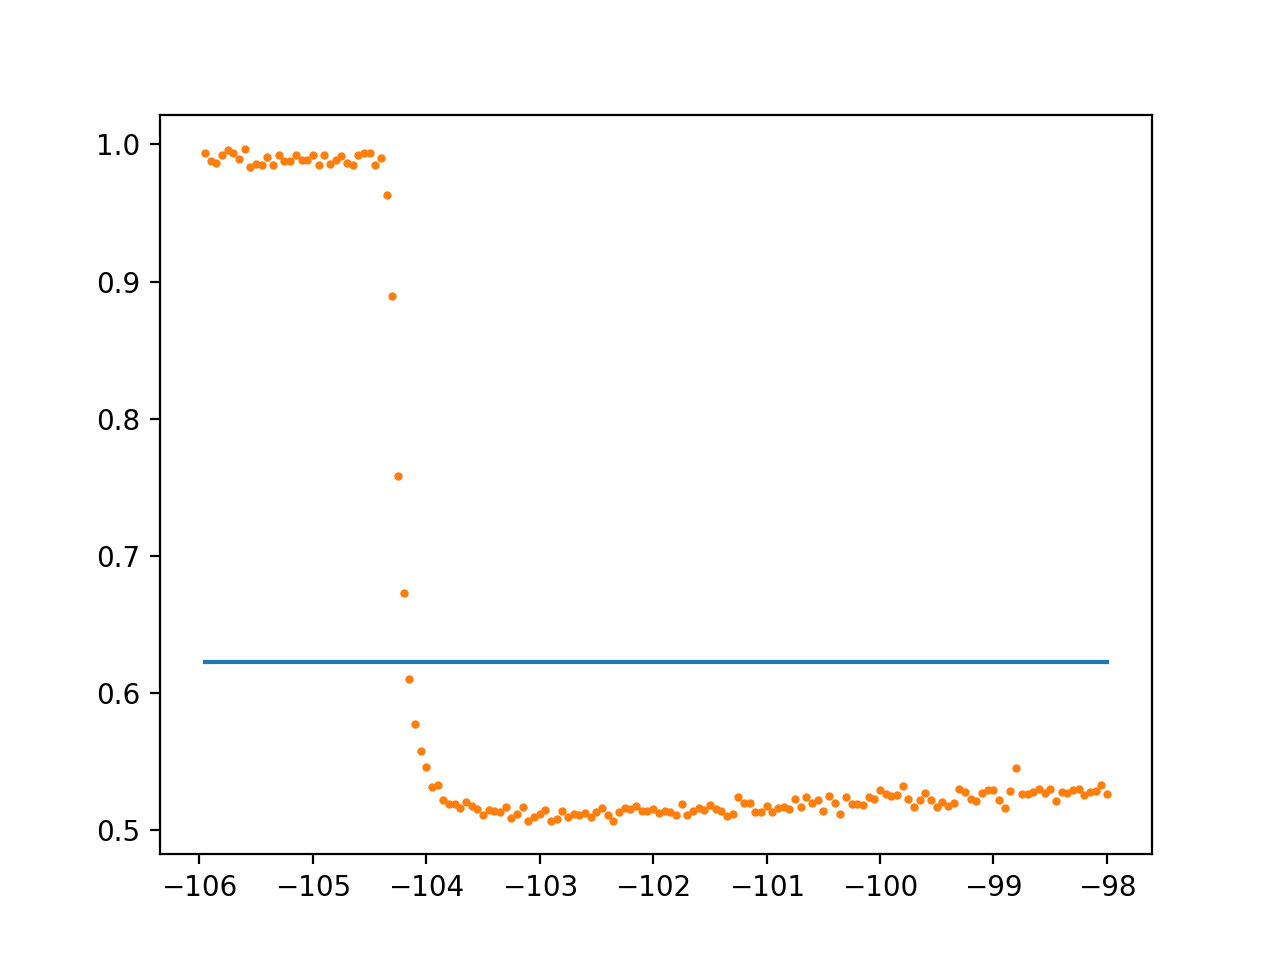

In [50]:
fig, ax = plt.subplots()
ax.plot(demag.delay, demag_fit, '-')
ax.plot(demag.delay, demag, 'o', ms=2)

In [65]:

azimuthal_corrected = azimuthal - noise

In [73]:
azimuthal

<xarray.Dataset>
Dimensions:   (delay: 160, delta_q: 544)
Coordinates:
  * delay     (delay) float64 5.95 5.9 5.85 5.8 5.75 ... -1.85 -1.9 -1.95 -2.0
    distance  (delta_q) float64 1.0 2.0 3.0 4.0 5.0 ... 541.0 542.0 543.0 544.0
  * delta_q   (delta_q) float64 0.001698 0.003395 0.005093 ... 0.8926 0.8942
Data variables:
    pumped    (delta_q, delay) float64 nan nan nan ... 4.001e-05 4.252e-05
    unpumped  (delta_q, delay) float64 nan nan nan ... 4.154e-05 4.187e-05

In [74]:
azimuthal - noise

<xarray.Dataset>
Dimensions:   (delay: 160, delta_q: 544)
Coordinates:
  * delay     (delay) float64 5.95 5.9 5.85 5.8 5.75 ... -1.85 -1.9 -1.95 -2.0
    distance  (delta_q) float64 1.0 2.0 3.0 4.0 5.0 ... 541.0 542.0 543.0 544.0
  * delta_q   (delta_q) float64 0.001698 0.003395 0.005093 ... 0.8926 0.8942
Data variables:
    pumped    (delta_q, delay) float64 nan nan nan ... -0.004197 -0.007214
    unpumped  (delta_q, delay) float64 nan nan nan ... -0.004196 -0.007215

<IPython.core.display.Javascript object>


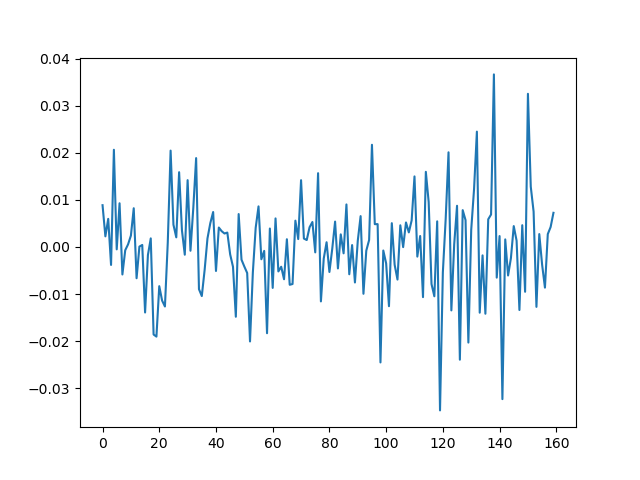

In [70]:
fig, ax = plt.subplots()
ax.plot(noise)

<IPython.core.display.Javascript object>


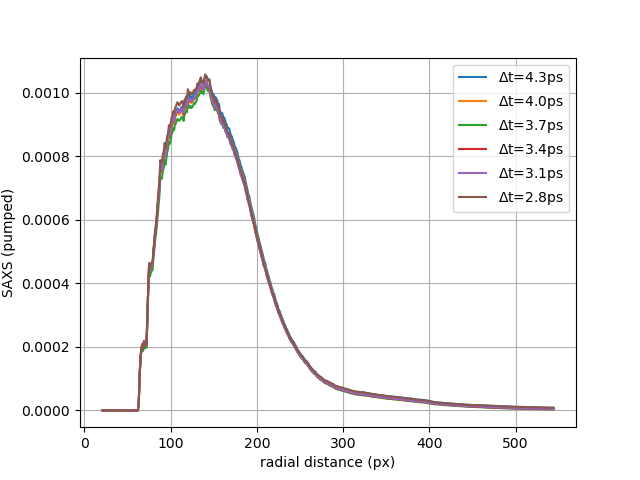

In [62]:
timepoints = np.arange(19, 35, 3)

fig, ax = plt.subplots()
for i in timepoints:
    tpos = t0 - float(im_pumped.scan_variable[i])
    ax.plot(ai.distance, ai(im_pumped_arranged[i] * dssc_mask) / norm,
            label=f'$\Delta$t={tpos:.1f}ps')
ax.legend()
ax.set_xlabel('radial distance (px)')
ax.set_ylabel('SAXS (pumped)')
ax.grid(True)

# fig.savefig(f'190920_run{run_nr}_dark{darkrun_nr}_azimuthal.png', dpi=300)